<a href="https://colab.research.google.com/github/zlakcswair/Python_Evaluaciones_202520/blob/main/Evaluaci%C3%B3n_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Evaluación 4 Python aplicado a la Ingeniería 202520

Docente: Miguel Ortiz Padilla

Estudiantes: Wilmer David jiménez Díaz, Santiago Ibarra Méndez, Tobías Lozano Florez

e-mails: wilmer.jimenez@upb.edu.co,
         santiago.ibarra@upb.edu.co,
         tobias.lozano@upb.edu.co

Fecha: 09/24/2025


--- Estadísticas para El Cairo ---
Promedio diario: 5828.88
Promedio mensual: 177295.17
Total anual: 2127542
Máxima radiación: 1042 en 2022-07-06 11:30:00
Mínima radiación: 0 en 2022-01-01 00:30:00

--- Estadísticas para Montería ---
Promedio diario: 5088.72
Promedio mensual: 154782.0
Total anual: 1857384
Máxima radiación: 1014 en 2022-04-22 12:00:00
Mínima radiación: 0 en 2022-01-01 00:00:00

=== ENERGÍA ANUAL ESTIMADA (Panel Solar 400W, modelo mejorado) ===
 Cairo (kWh)  Montería (kWh)
      713.75          614.33


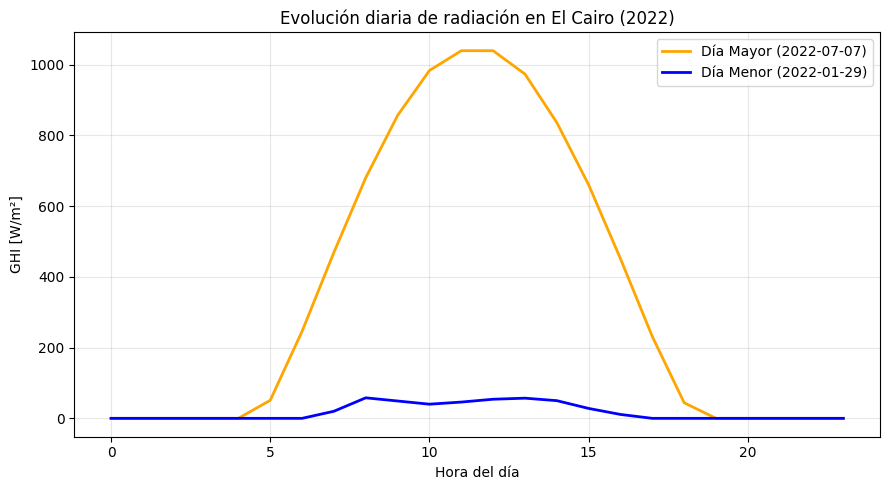

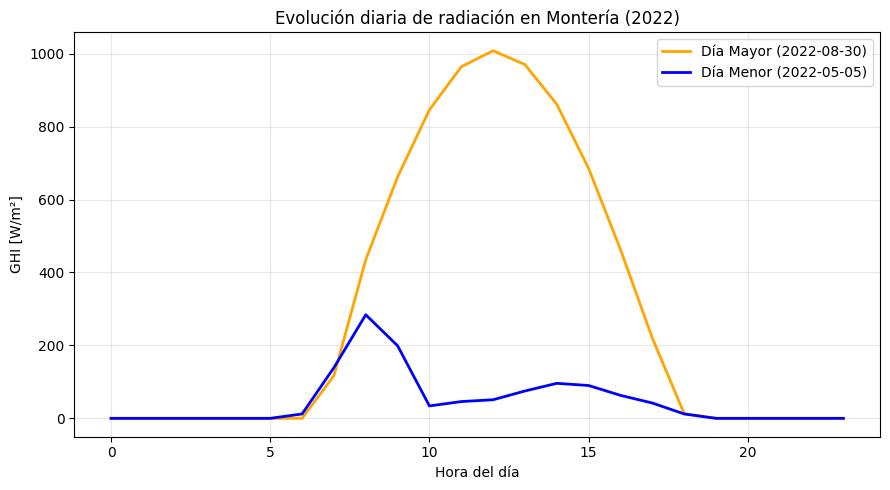

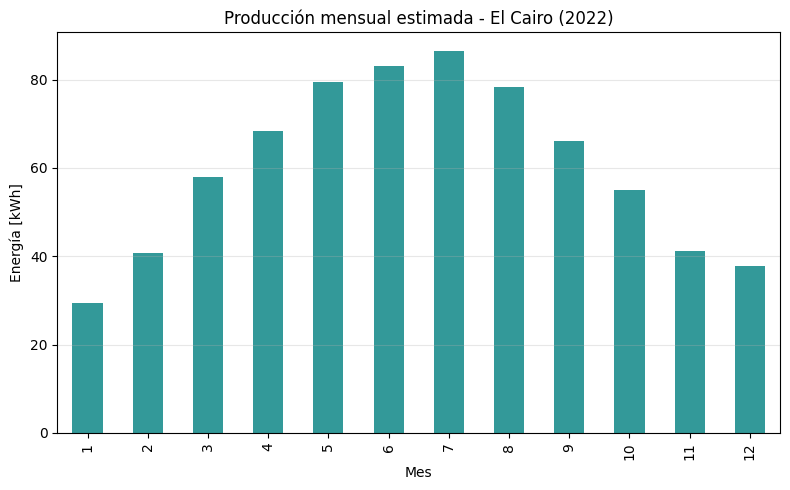

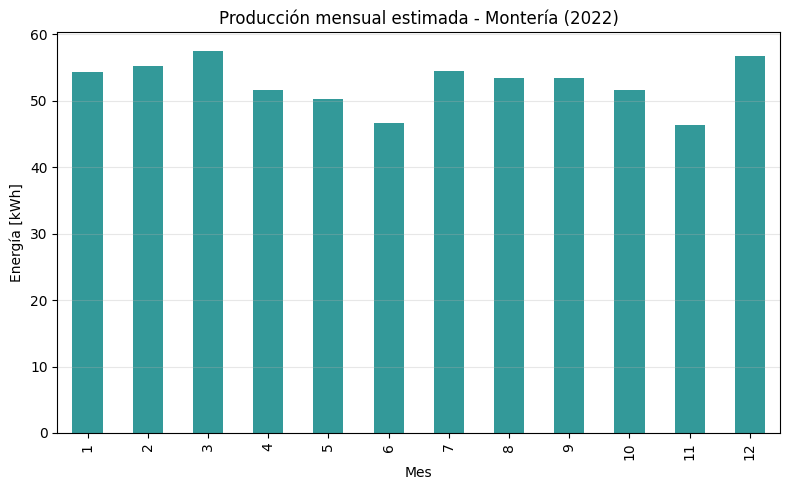

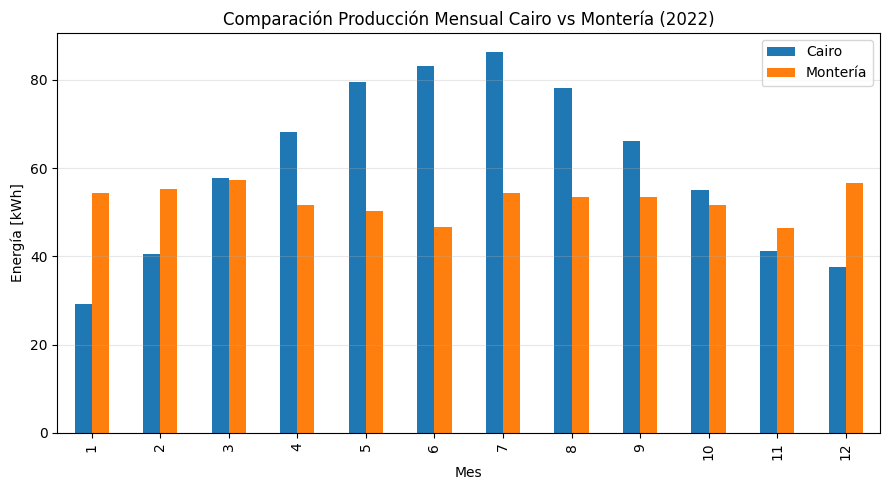

In [ ]:
# --- Evaluación 4: Análisis de Datos con Python ---
# Autor: Wilmer Jimenez
# Curso: Python aplicado a la Ingeniería
# Universidad Pontificia Bolivariana – Montería

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. Lectura de datos
# =========================
cairo = pd.read_csv("Cairo_data.csv", skiprows=2)
monteria = pd.read_csv("Monteria_data.csv", skiprows=2)

# Convertir a datetime
cairo['datetime'] = pd.to_datetime(cairo[['Year','Month','Day','Hour','Minute']])
monteria['datetime'] = pd.to_datetime(monteria[['Year','Month','Day','Hour','Minute']])

# =========================
# 2. Selección de variables
# =========================
vars_interes = ['datetime','Year','Month','Day','Hour','Minute','GHI','Temperature','Wind Speed']
cairo = cairo[vars_interes]
monteria = monteria[vars_interes]

# =========================
# 3. Estadísticas descriptivas (con numpy)
# =========================
def estadisticas_radiacion(df, nombre):
    print(f"\n--- Estadísticas para {nombre} ---")

    # Agrupación usando pandas pero cálculo con numpy
    diaria = df.groupby(df['datetime'].dt.date)['GHI'].sum()
    mensual = df.groupby(df['Month'])['GHI'].sum()

    diaria_np = diaria.to_numpy()
    mensual_np = mensual.to_numpy()

    anual = np.sum(diaria_np)

    print("Promedio diario:", np.mean(diaria_np).round(2))
    print("Promedio mensual:", np.mean(mensual_np).round(2))
    print("Total anual:", anual.round(2))

    max_idx = np.argmax(df['GHI'].to_numpy())
    min_idx = np.argmin(df['GHI'].to_numpy())
    max_hora = df.iloc[max_idx]
    min_hora = df.iloc[min_idx]

    print("Máxima radiación:", max_hora['GHI'], "en", max_hora['datetime'])
    print("Mínima radiación:", min_hora['GHI'], "en", min_hora['datetime'])

    return diaria_np, mensual_np, anual

cairo_diaria, cairo_mensual, cairo_anual = estadisticas_radiacion(cairo, "El Cairo")
monteria_diaria, monteria_mensual, monteria_anual = estadisticas_radiacion(monteria, "Montería")

# =========================
# 4. Modelo de Panel Solar (OOP) Mejorado con numpy
# =========================
class PanelSolar:
    def __init__(self, potencia_nominal=400, area=1.7, eficiencia=0.20,
                 coef_temp=-0.004, temp_nominal=25, coef_viento=0.002):
        self.potencia_nominal = potencia_nominal
        self.area = area
        self.eficiencia = eficiencia
        self.coef_temp = coef_temp
        self.temp_nominal = temp_nominal
        self.coef_viento = coef_viento

    def energia_instantanea(self, irr, temp, viento):
        irr = np.array(irr)
        temp = np.array(temp)
        viento = np.array(viento)

        factor_temp = 1 + self.coef_temp * (temp - self.temp_nominal)
        factor_viento = 1 + self.coef_viento * (viento - 1)

        return irr * self.area * self.eficiencia * factor_temp * factor_viento

    def energia_total(self, df):
        energia = self.energia_instantanea(df['GHI'], df['Temperature'], df['Wind Speed'])
        return np.sum(energia)

# Crear panel de referencia
panel = PanelSolar()

print("\n=== ENERGÍA ANUAL ESTIMADA (Panel Solar 400W, modelo mejorado) ===")
resumen = pd.DataFrame({
    "Cairo (kWh)": [round(panel.energia_total(cairo)/1000,2)],
    "Montería (kWh)": [round(panel.energia_total(monteria)/1000,2)]
})
print(resumen.to_string(index=False))

# =========================
# 5. Visualizaciones
# =========================

# (a) Evolución en días representativos
def graficar_dias(df, nombre):
    diaria = df.groupby(df['datetime'].dt.date)['GHI'].sum()
    max_dia = diaria.idxmax()
    min_dia = diaria.idxmin()

    plt.figure(figsize=(9,5))
    for dia, label, color in [(max_dia,"Mayor","orange"),(min_dia,"Menor","blue")]:
        subset = df[df['datetime'].dt.date == dia]
        horas = subset['datetime'].dt.hour.to_numpy()
        ghi = subset['GHI'].to_numpy()
        plt.plot(horas, ghi, label=f"Día {label} ({dia})", lw=2, color=color)
    plt.title(f"Evolución diaria de radiación en {nombre} (2022)")
    plt.xlabel("Hora del día")
    plt.ylabel("GHI [W/m²]")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

graficar_dias(cairo, "El Cairo")
graficar_dias(monteria, "Montería")

# (b) Producción de energía mensual
def energia_mensual(df, panel, nombre):
    mensual = df.groupby(df['Month'])['GHI'].sum()
    energia = []
    for val in mensual.to_numpy():
        energia.append(panel.energia_instantanea(val, 25, 1)/1000)  # kWh (condiciones estándar)
    energia = np.array(energia)

    plt.figure(figsize=(8,5))
    plt.bar(np.arange(1,13), energia, color="teal", alpha=0.8)
    plt.title(f"Producción mensual estimada - {nombre} (2022)")
    plt.ylabel("Energía [kWh]")
    plt.xlabel("Mes")
    plt.grid(axis="y", alpha=0.3)
    plt.tight_layout()
    plt.show()
    return energia

energia_cairo = energia_mensual(cairo, panel, "El Cairo")
energia_monteria = energia_mensual(monteria, panel, "Montería")

# (c) Comparación Cairo vs Montería
df_comp = pd.DataFrame({
    "Mes": np.arange(1,13),
    "Cairo": energia_cairo,
    "Montería": energia_monteria
})
df_comp.set_index("Mes").plot(kind="bar", figsize=(9,5))
plt.title("Comparación Producción Mensual Cairo vs Montería (2022)")
plt.ylabel("Energía [kWh]")
plt.xlabel("Mes")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
